Copyright by Dr. Carl-Magnus Svensson
Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge
https://www.leibniz-hki.de/en/applied-systems-biology.html
HKI-Center for Systems Biology of Infection
Leibniz Institute for Natural Product Research and Infection Biology -
Hans Knöll Insitute (HKI)
Adolf-Reichwein-Straße 23, 07745 Jena, Germany

# Analysis of simulated tracks

In [1]:
from tqdm import tqdm
import json
import os
import glob
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
from Peroxisome_HMM import viterbi, Baum_Welch, convert_to_cartesian, convert_to_planar, flatten_list

## Load data.

In [3]:
mixed_data = pd.read_csv('./Simulated_data/Mixed_PRW_tracks.csv', sep=',')

### Plot speed and angle distributions for the mixed tracks

In [7]:
l_s1 = []
l_s2 = []
alpha_s1 = []
alpha_s2 = []

for tr in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==tr]
    X = np.array([track0['X'], track0['Y']]).T
    s = np.array(track0['s'])
    l, alpha = convert_to_planar(X,1)
    s = s[1:-1]
    straight = (s == 1)
    brown = (s == 0)
    l_s2.append(l[straight])
    l_s1.append(l[brown])
    alpha_s1.append(alpha[straight])
    alpha_s2.append(alpha[brown])
    
l_s1 = flatten_list(l_s1)
l_s2 = flatten_list(l_s2)
alpha_s1 = flatten_list(alpha_s1)
alpha_s2 = flatten_list(alpha_s2)


(array([ 572.,  677.,  860., 1286., 1744., 1724., 1245.,  873.,  622.,
         559.]),
 array([-3.14088776e+00, -2.51305283e+00, -1.88521789e+00, -1.25738296e+00,
        -6.29548031e-01, -1.71309927e-03,  6.26121833e-01,  1.25395676e+00,
         1.88179170e+00,  2.50962663e+00,  3.13746156e+00]),
 <BarContainer object of 10 artists>)

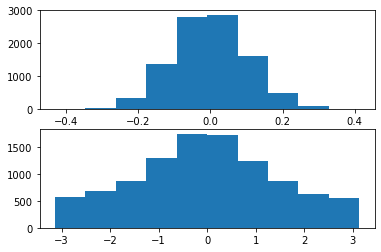

In [8]:
plt.subplot(2,1,1)
plt.hist(alpha_s1)
plt.subplot(2,1,2)
plt.hist(alpha_s2)

(array([   3.,   51.,  318., 1188., 2429., 2836., 1924.,  718.,  147.,
          24.]),
 array([ 4.3266562 ,  5.41110081,  6.49554543,  7.57999005,  8.66443467,
         9.74887929, 10.83332391, 11.91776852, 13.00221314, 14.08665776,
        15.17110238]),
 <BarContainer object of 10 artists>)

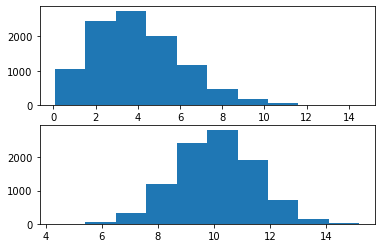

In [9]:
plt.subplot(2,1,1)
plt.hist(l_s1)
plt.subplot(2,1,2)
plt.hist(l_s2)

### Plot GT track with states color coded

([], [])

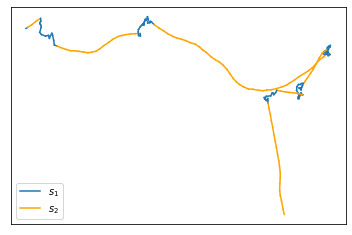

In [10]:
c1 = '#1f77b4'
c2 = 'orange'
track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
s_est = np.array(track0['s'])
lab1=True
lab2=True
for ii in range(track0['X'].shape[0]-2):
    if s_est[ii+1] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+1:ii+3], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])

### Screen tracks and fit parameters using Baum-Welch for each track

In [11]:
res_dic = {}
counter = 0
for tr in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==tr]
    Tm = np.array([[0.95, 0.05],[0.3, 0.7]]) 
    pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
    mu_l = np.array([-1.11, 0.5])
    sigma_l = np.array([0.75, 0.75])
    sigma_alpha_2 = 0.45
    
    X = np.array([track0['X'], track0['Y']]).T
    dt = track0['t'].iloc[1]-track0['t'].iloc[0]
    l, alpha = convert_to_planar(X,dt)
    #print(alpha.shape)
    o = np.array([l[:], alpha]).T
    o_log = np.copy(o[:])
    o_log[:,0] = np.log(o[:,0])
    run_dic = {"track_id" : str(tr)}
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], Tm, pi, mu_l, sigma_l, sigma_alpha_2, fit_mu=True, fit_sigma=True)
    converged = False
    iters = 0
    while not converged and iters < 1000:
        iters += 1
        mu_l_old = np.copy(mu_l_new)
        sigma_l_old = np.copy(sigma_l_new)
        pi_old = np.copy(pi_new)
        T_old = np.copy(T_new)
        mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new, fit_mu=True, fit_sigma=True)
        diff_m = mu_l_new - mu_l_old
        diff_s = sigma_l_new - sigma_l_old
        diff_p = pi_old - pi_new
        diff_T = T_old - T_new
        d_vector = [np.sqrt(diff_m.dot(diff_m)), 
                    np.sqrt(diff_s.dot(diff_s)), 
                    np.sqrt(diff_p.dot(diff_p)), 
                    np.linalg.norm(diff_T)]
        #print(np.max(d_vector))
        if np.max(d_vector) < 0.001:
            converged = True

    run_dic["mu_l"] = np.copy(mu_l_new[:])
    run_dic["sigma_l"] = np.copy(sigma_l_new[:])
    run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
    run_dic["T"] = np.copy(T_new[:])
    run_dic["pi"] = np.copy(pi_new[:])
    res_dic[counter] = run_dic
    counter += 1
    
with open("./Simulated_data/params_mixed_data.json", "w") as write_file:
    json.dump(res_dic, write_file, cls=NumpyArrayEncoder)

### Plot fitted parameters

In [12]:
mu = []
T = []
pi = []
sigma = []
for key in res_dic.keys():
    mu.append(res_dic[key]['mu_l'])
    pi.append(res_dic[key]['pi'])
    T.append(res_dic[key]['T'])
    sigma.append(res_dic[key]['sigma_l'])
    
mu = np.array(mu)
T = np.array(T)
pi = np.array(pi)
sigma = np.array(sigma)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f134c6f15d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f134d852510>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f134c6ee650>,
 'medians': [<matplotlib.lines.Line2D at 0x7f134c6d7c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f134cc89a10>,
 'means': []}

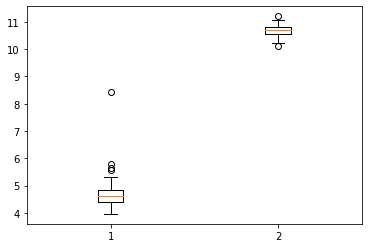

In [15]:
plt.boxplot(np.exp(mu+sigma/2))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f134c592710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f134c592f90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f134c5922d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f134c595890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f134c595cd0>,
 'means': []}

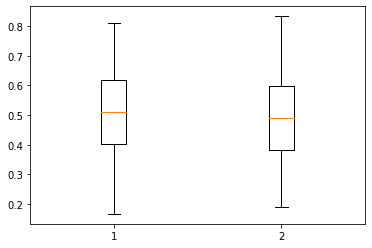

In [16]:
plt.boxplot(pi)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f132a957f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f132a95e810>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f132a957b10>,
 'medians': [<matplotlib.lines.Line2D at 0x7f132a8e8110>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f132a8e8550>,
 'means': []}

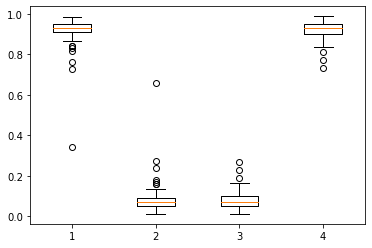

In [17]:
T.shape
plt.boxplot(T.reshape(100,4))

0.026363636363636363


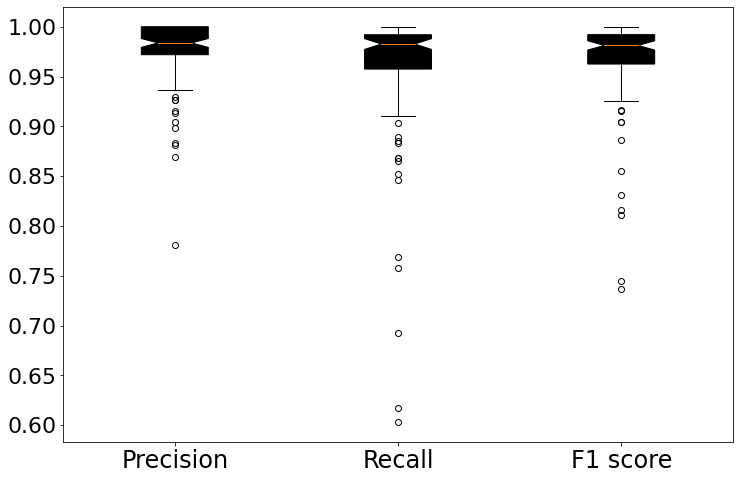

In [19]:
err = []
TP = []
FP = [] 
FN = []
for ii in np.unique(mixed_data['track_id']):
    track0 = mixed_data.loc[mixed_data['track_id']==ii]
    X = np.array([track0['X'], track0['Y']]).T
    dt = track0['t'].iloc[1]-track0['t'].iloc[0]
    l, alpha = convert_to_planar(X,dt)
    T = res_dic[ii]['T']
    mu = res_dic[ii]['mu_l']
    sigma = res_dic[ii]['sigma_l']
    pi = res_dic[ii]['pi']
    o = np.array([l[:], alpha]).T
    s_est, D, E = viterbi(T, pi, mu, sigma, 0.45, o)
    err.append(sum(abs(track0['s'].iloc[1:-1] - s_est))/s_est.shape[0])
    st = track0['s'].iloc[1:-1]
    TP.append(np.sum(np.array((st==1))*np.array((s_est==1))))
    FP.append(np.sum(np.array((st==0))*np.array((s_est==1))))
    FN.append(np.sum(np.array((st==1))*np.array((s_est==0))))

precision = np.array(TP)/(np.array(TP)+np.array(FP))
recall = np.array(TP)/(np.array(TP)+np.array(FN))
fig = plt.figure(figsize=(12,8))

pos = np.array([1, 3])
width = 0.2
box1 = plt.boxplot([ precision, recall, 2*(precision*recall)/(precision+recall)], patch_artist=True, notch=True)
#box2 = plt.boxplot(recall, positions=pos-2*width, widths=width, patch_artist=True, notch=True)
#box3 = plt.boxplot(precision, positions=pos-width, widths=width, patch_artist=True, notch=True)

colors = ['black', 'black', 'black']
#box1 = plt.boxplot(1-err, patch_artist=True, notch=True)
for p1, c in zip(box1['boxes'], colors):
    p1.set_facecolor(c)
    
plt.ylabel('', size=24)
plt.xticks([1,2,3], ['Precision', 'Recall', 'F1 score'], size=24)
plt.yticks(size=22)

print(np.mean(err))

plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/error_box.svg')

### Use Viterbi's algorithm to predict states for each step of a track

In [20]:
track0 = mixed_data.loc[mixed_data['track_id']==0]
dt = track0['t'].iloc[1]-track0['t'].iloc[0]
l, alpha = convert_to_planar(X,dt)
T = res_dic[0]['T']
mu = res_dic[0]['mu_l']
sigma = res_dic[0]['sigma_l']
pi = res_dic[0]['pi']
o = np.array([l[:], alpha]).T
print(pi)
s_est, D, E = viterbi(T, pi, mu, sigma, 0.45, o)

[0.50479536 0.49520464]


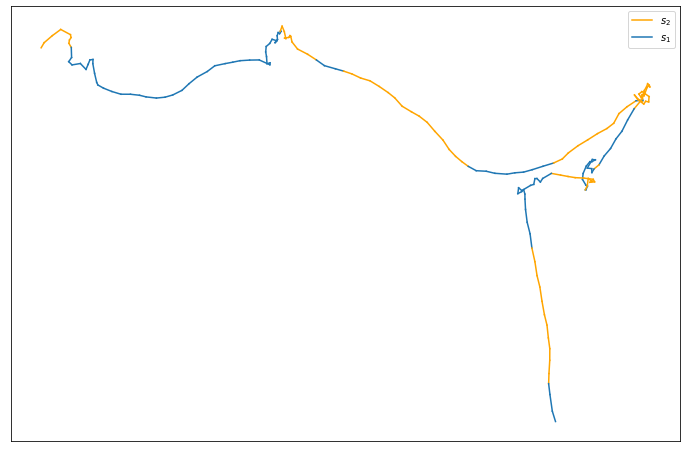

In [24]:
fig = plt.figure(figsize=(12,8))
c1 = '#1f77b4'
c2 = 'orange'
#track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
#s_est = np.array(track0['s'])
lab1=True
lab2=True

for ii in range(track0['X'].shape[0]-3):
    if s_est[ii] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Plots/simulated_track_1_Viterbi_fitted.svg')
plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/simulated_track_1_Viterbi_fitted.svg')

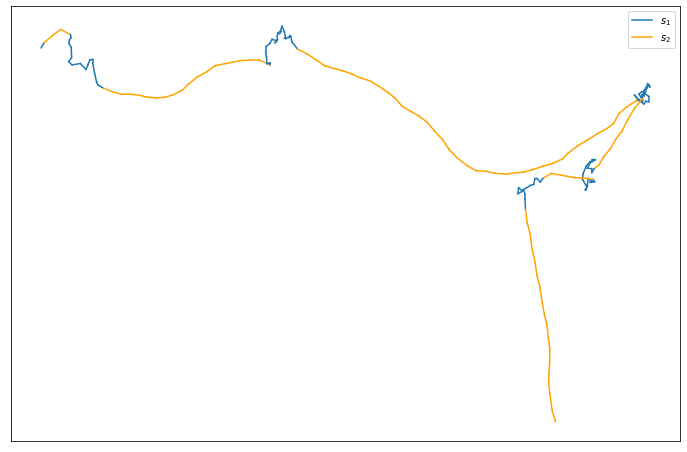

In [23]:
c1 = '#1f77b4'
c2 = 'orange'
fig = plt.figure(figsize=(12,8))
#track0 = mixed_data.loc[mixed_data['track_id']==0]
#plt.plot(track0['X'].iloc[0:], track0['Y'].iloc[0:])
#s_est = np.array(track0['s'])
lab1=True
lab2=True
s = np.array(track0['s'])

for ii in range(track0['X'].shape[0]-3):
    if s[ii+1] == 0:
        if lab1:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1, label=r'$s_1$')
            lab1=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c1)
    else:
        if lab2:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2, label=r'$s_2$')
            lab2=False
        else:
            plt.plot(track0['X'].iloc[ii+1:ii+3], track0['Y'].iloc[ii+2:ii+4], c=c2)
        #print(o[ii])
plt.legend()
plt.xticks([])
plt.yticks([])
#plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Plots/simulated_track_1_GT.svg')
plt.savefig('/home/svensson/Dropbox/Projects/Perioxomes/Manuscript/simulated_track_1_GT.svg')